In [2]:
%matplotlib inline
import warnings

warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import mdtraj as md
from itertools import combinations

In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
# import tidynamics as td

## Load and inspect the data

In [4]:
traj = md.load('data/water_nojump_3.xtc',top= 'data/water_top.pdb')
com = md.compute_center_of_mass(traj)
com.shape

/Users/robertarbon/miniconda3/envs/science/lib/python3.6/site-packages/pyemma/__init__.py:92: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.6, you have 2.5.5.
  .format(latest=latest, current=current), category=UserWarning)


(10000001, 3)

In [5]:
traj.timestep

0.1

In [6]:
df = pd.DataFrame(com, columns=['x', 'y', 'z'])
df['t'] = traj.time/1000

df_melt = pd.melt(frame=df, id_vars=['t'], value_vars=['x', 'y', 'z'], var_name='coord', )

df_melt.head()

,t,coord,value
0,0.0000,x,2.322035
1,0.0001,x,2.317498
2,0.0002,x,2.348874
3,0.0003,x,2.367788
4,0.0004,x,2.341420


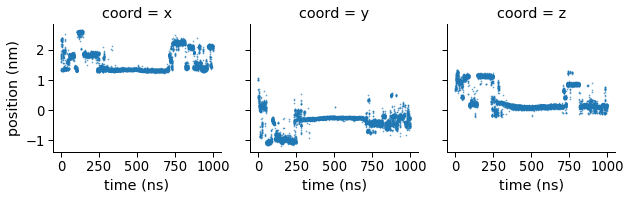

In [7]:
with sns.plotting_context('paper', font_scale=1.5):
    g = sns.FacetGrid(df_melt.iloc[::1000,:], col='coord')
    g.map(plt.scatter, 't', 'value', alpha=0.5, s=1)
    g.set_axis_labels('time (ns)', 'position (nm)')
    plt.savefig('thesis chapter/traj_3_xyz.png', bbox_inches='tight')

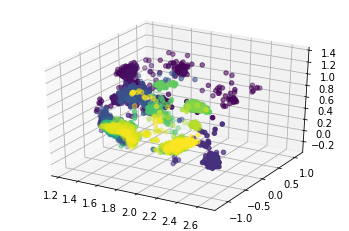

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(xs=com[::1000,0], ys=com[::1000,1], zs=com[::1000,2], c=df['t'][::1000])

### Split data into 1ns pieces

This is because we have a wide variety of behaviour across the trajectory and we only want to focus on small chunks at a time. 

In [9]:
dt_ps = traj.timestep
dt_ns = dt_ps/1000 # in ns
window = 1 # window size in ns
n_frames = int(window/dt_ns) # number of frames in a window
n_splits = com.shape[0]//n_frames # number of windows in trajectory
traj_split = np.array_split(com, n_splits) # the split up 

In [10]:
sample = pd.DataFrame(traj_split[136])
sample.head()

,0,1,2
0,2.578284,-0.985622,0.214775
1,2.611725,-1.000329,0.189633
2,2.612940,-0.944668,0.206004
3,2.637449,-0.994035,0.204889
4,2.605083,-0.988115,0.188019


## Specific timeslice

In [16]:
np.random.seed(42)
axis = ['x', 'y', 'z']
idx = 0


### Coordinates

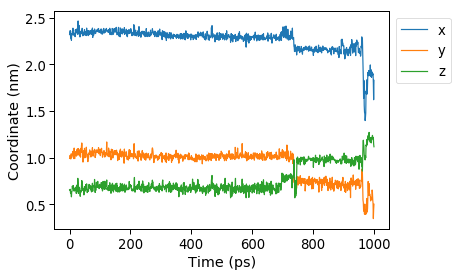

In [17]:
with sns.plotting_context('paper', font_scale=1.5):
    stride = 10
    t = np.arange(traj_split[idx].shape[0])*dt_ps
    fig, ax = plt.subplots()
    for i in range(len(axis)):
        ax.plot(t[::stride], traj_split[idx][::stride, i], label=axis[i])
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    ax.set_ylabel('Coordinate (nm)')
    ax.set_xlabel('Time (ps)')
    plt.savefig('images/xyz-slice-{}.png'.format(idx), bbox_inches='tight', dpi=450)

### TICA

(0, 500)

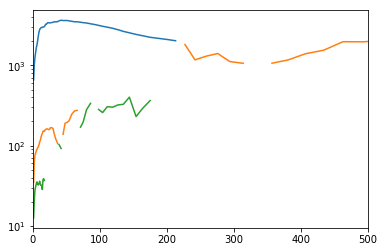

In [24]:
tica_lags = np.unique((np.logspace(np.log10(1), np.log10(600), 100)).astype(int))
ticas = [coor.tica(traj_split[idx], lag=int(lag/dt_ps), dim=3,  kinetic_map=True) for lag in tica_lags]
tica_eigs = np.concatenate([t.eigenvalues[:, np.newaxis] for t in ticas ], axis=1)
tica_ts = np.concatenate([t.timescales[:, np.newaxis] for t in ticas ], axis=1)
tica_ts = -tica_lags/dt_ps/np.log(tica_eigs)

plt.plot(tica_lags, tica_ts.T)
plt.yscale('log')
plt.xlim(0, 500)

### VAMP

In [25]:
vamps = [coor.vamp(traj_split[idx], lag=int(lag/float(dt_ps)), dim=3, scaling='km', right=True) for lag in tica_lags]
vamp_sv = np.concatenate([t.singular_values[:, np.newaxis] for t in vamps ], axis=1)
vamp_ts = -tica_lags/dt_ps/np.log(vamp_sv)


### MSM

In [26]:
dtrajs_obj = coor.cluster_kmeans(traj_split[idx], k = np.sqrt(n_frames).astype(int), max_iter=100)
dtrajs = dtrajs_obj.dtrajs

In [27]:
its = msm.its(dtrajs, lags=(tica_lags/dt_ps).astype(int), nits=5, errors='bayes')

In [28]:
vamp10 = vamps[1]
tica10 = ticas[1]
mm10 = msm.estimate_markov_model(dtrajs, lag=int(10/dt_ps))
mm100 = msm.estimate_markov_model(dtrajs, lag=int(100/dt_ps))
hmm10 = mm10.coarse_grain(2)
hmm100 = mm100.coarse_grain(2)
mms = [hmm10, vamp10]

In [29]:
titles = [r'HMM($\tau$=10ps)', r'VAMP($\tau$=10ps)']


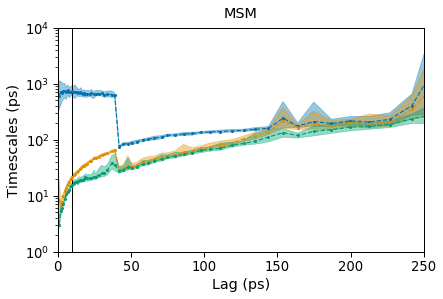

In [35]:
with sns.plotting_context('paper', font_scale=1.5):
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
    if not isinstance(axes, list):
        axes = [axes]
    xmax, ymax = 250, 10**4
    nits = 3
    colors = sns.color_palette('colorblind', nits)
    
    srt = np.argsort(its.lags)
    lags = its.lags
    for i in range(nits):
        axes[0].plot(
                lags[srt] * dt_ps, its.get_sample_mean(process=i)[srt] * dt_ps, marker='o',
                color=colors[i % len(colors)], linestyle='dashed', markersize=2)
        (lconf, rconf) = its.get_sample_conf(0.95, i)
        axes[0].fill_between(
            lags[srt]*dt_ps, lconf[srt]*dt_ps , rconf[srt]*dt_ps,
            alpha=0.4, color=colors[i % len(colors)])
    
    axes[0].set_yscale('log')
    axes[0].set_title('MSM', pad=10)
    axes[0].set_xlim(0, xmax)
    axes[0].set_ylim(1, ymax)
    
    
#     axes[1].plot(tica_lags, vamp_ts.T, marker='o', ms=2)
#     axes[1].set_yscale('log')
#     axes[1].set_xlim(0, xmax)
#     axes[1].set_title('VAMP', pad=10)
#     axes[1].set_xlabel(r'Lagtime/$\tau$, (ps)')
    


    for ax in axes:
        ax.vlines(10, 0, ymax, color='k', lw=1)
        ax.set_ylabel('Timescales (ps)')
    axes[-1].set_xlabel('Lag (ps)')
    

    plt.tight_layout(h_pad=0.1, w_pad=0.1, pad=0.1)
    plt.savefig('images/msm-its-slice-{}.png'.format(idx), bbox_inches='tight', dpi=450)

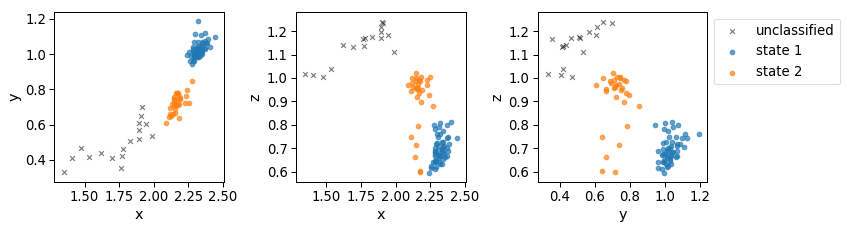

In [59]:

combs = list(combinations(range(3), 2))
ccs = dtrajs_obj.clustercenters

with sns.plotting_context('paper', font_scale=1.5):
    ncols= len(combs)
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(6*(ncols-1),4))
    obs = hmm10.observable_set
    non_obs = np.array([x for x in range(ccs.shape[0]) if not x in obs])
    
    mas = hmm10.metastable_assignments
    n_states = np.max(mas)+1
    for j in range(len(combs)): 
        axes[j].scatter(x = ccs[non_obs, combs[j][0]], y = ccs[non_obs, combs[j][1]], 
                          c='k',marker='x', alpha=0.5, label='unclassified')
        for i in range(n_states):
            obs_idx = obs[np.where(mas==i)[0]]
            axes[j].scatter(x = ccs[obs_idx, combs[j][0]], y = ccs[obs_idx, combs[j][1]], 
                          alpha=0.7, label='state {}'.format(i+1))
            
        axes[j].set_ylabel(axis[combs[j][1]])
        axes[j].set_xlabel(axis[combs[j][0]])
        ratio = 1
        axes[j].set_aspect(1.0/axes[j].get_data_ratio()*ratio)

    axes[-1].legend(bbox_to_anchor=(1,1), loc='upper left')
    plt.tight_layout()
    plt.savefig('images/hmm-classification-slice-{}.png'.format(idx), bbox_inches='tight', dpi=450)

In [ ]:
np.arange()

In [36]:

# combs = list(combinations(range(3), 2))
# ccs = dtrajs_obj.clustercenters
# with sns.plotting_context('paper', font_scale=1.5):
#     fig, axes = plt.subplots(nrows=len(mms), ncols=len(combs), sharex='col', sharey='row')
#     for i in range(len(mms)):
#         if i < len(mms)/2:
#             idxs = mms[i].observable_set
#             cols = mms[i].metastable_assignments
#         else:
#             cols = mms[i].transform(ccs)[:, 0]
#             idxs = np.arange(cols.shape[0])
#         if cols[0] < 0: cols = cols*(-1)
#         for j in range(len(combs)): 
#             axes[i, j].scatter(x = ccs[idxs, combs[j][0]], y = ccs[idxs, combs[j][1]], 
#                               c=cols, alpha=0.5)

#             axes[i, j].set_ylabel(axis[combs[j][1]])
#             axes[i, j].set_xlabel(axis[combs[j][0]])
#             if j == 1:
#                 axes[i, j].set_title(titles[i], pad=10)
#     plt.tight_layout(h_pad=0.1, w_pad=0.1, pad=0.1)